# Tarea 1 2025

Instrucciones

Su notebook con las respuestas a la tarea se deben entregar a mas tardar el dia 21/04/25 hasta las 21:00, subiendolo al repositorio en la carpeta tareas/2025.

Es importante considerar que el código debe poder ejecutarse en cualquier computadora con la data original del repositorio. Recordar la convencion para el nombre de archivo ademas de incluir en su documento titulos y encabezados por seccion. La data a utilizar es machine_failure_data.csv.

Las variables tienen la siguiente descripcion:

Date: data medida en frecuencia diaria
Location: ubicacion del medidor
Min_Temp: temperatura minima observada
Max_Temp: temperatura maxima observada
Leakage: Filtracion medida en el area
Evaporation: Tasa de evaporacion
Electricity: Consumo electrico KW
Parameter#: Diferentes sensores de reportando direccion y velocidad de viento en distintos momentos del dia, asi como otras metricas relevantes.
Failure today: El sensor reporta fallo (o no)

In [231]:
#Cargamos librerías
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn
import scipy 
import seaborn as sns
import warnings
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

%matplotlib inline




# Descripcion de la Data y limpieza


1.-Cargar la base de datos en el ambiente. Identifique los tipos de datos que se encuentran en la base, realice estadisticas descriptivas sobre las variables importantes (Hint: Revisar la distribuciones, datos faltantes, outliers, etc.) y limpie las variables cuando sea necesario.

**R**: Cargamos la data y cambiamos nombres de las variables para mas comodidad, vemos los tipos de variables y sus estadisticas descriptivas, luego realizamos las limpiezas correspondientes.

In [232]:
url="https://raw.githubusercontent.com/juancaros/LAB-MAA/refs/heads/main/data/machine_failure_data.csv"
df=pd.read_csv(url)

df=df.rename(columns={"Parameter1_Speed":"P1_Speed",
                     "Parameter1_Dir":"P1_Dir",
                      "Parameter2_3pm":"P2_3pm",
                     "Parameter2_9am":"P2_9am",
                     "Parameter3_9am":"P3_9am",
                     "Parameter3_3pm":"P3_3pm",
                    "Parameter4_9am":"P4_9am",
                    "Parameter4_3pm":"P4_3pm",
                    "Parameter5_9am":"P5_9am",
                    "Parameter5_3pm":"P5_3pm",
                    "Parameter6_9am":"P6_9am",
                    "Parameter6_3pm":"P6_3pm",
                    "Parameter7_9am":"P7_9am",
                    "Parameter7_3pm":"P7_3pm",
                    })

df['Failure_bin']=df['Failure_today'].apply(lambda x:1 if x=='Yes' else 0) #Pasamos la variables Failuere_today a binaria
df.drop('Failure_today', axis=1, inplace=True)


df.info()
df.describe()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 22 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Date         142193 non-null  object 
 1   Location     142193 non-null  int64  
 2   Min_Temp     141556 non-null  float64
 3   Max_Temp     141871 non-null  float64
 4   Leakage      140787 non-null  float64
 5   Evaporation  81350 non-null   float64
 6   Electricity  74377 non-null   float64
 7   P1_Dir       132863 non-null  object 
 8   P1_Speed     132923 non-null  float64
 9   P2_9am       132180 non-null  object 
 10  P2_3pm       138415 non-null  object 
 11  P3_9am       140845 non-null  float64
 12  P3_3pm       139563 non-null  float64
 13  P4_9am       140419 non-null  float64
 14  P4_3pm       138583 non-null  float64
 15  P5_9am       128179 non-null  float64
 16  P5_3pm       128212 non-null  float64
 17  P6_9am       88536 non-null   float64
 18  P6_3pm       85099 non-n

,Location,Min_Temp,Max_Temp,Leakage,Evaporation,Electricity,P1_Speed,P3_9am,P3_3pm,P4_9am,P4_3pm,P5_9am,P5_3pm,P6_9am,P6_3pm,P7_9am,P7_3pm,Failure_bin
count,142193.000000,141556.000000,141871.000000,140787.000000,81350.000000,74377.000000,132923.000000,140845.000000,139563.000000,140419.000000,138583.000000,128179.000000,128212.000000,88536.000000,85099.000000,141289.000000,139467.000000,142193.000000
mean,24.740655,12.186400,23.226784,2.349974,5.469824,7.624853,39.984292,14.001988,18.637576,68.843810,51.482606,1017.653758,1015.258204,4.437189,4.503167,16.987509,21.687235,0.221213
std,14.237503,6.403283,7.117618,8.465173,4.188537,3.781525,13.588801,8.893337,8.803345,19.051293,20.797772,7.105476,7.036677,2.887016,2.720633,6.492838,6.937594,0.415065
min,1.000000,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,12.000000,7.600000,17.900000,0.000000,2.600000,4.900000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,25.000000,12.000000,22.600000,0.000000,4.800000,8.500000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,37.000000,16.800000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.000000
max,49.000000,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,1.000000


In [233]:
# Pasamos los variables de direcciones a valores númericos, en este caso los pasamos a radianes, seprando cada variable
# en seno y coseno según corresponda
rad_map = {'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
           'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
           'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
           'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5}
#Pasamos a grados
df['P1_Dir'] = df['P1_Dir'].map(rad_map)
df['P2_9am'] = df['P2_9am'].map(rad_map)
df['P2_3pm'] = df['P2_3pm'].map(rad_map)
 
 # Pasamos a radianes
df['P1_Dir_sin'] = np.sin(np.radians(df['P1_Dir']))
df['P1_Dir_cos'] = np.cos(np.radians(df['P1_Dir']))
df['P2_9am_sin'] = np.sin(np.radians(df['P2_9am']))
df['P2_9am_cos'] = np.cos(np.radians(df['P2_9am']))
df['P2_3pm_sin'] = np.sin(np.radians(df['P2_3pm']))
df['P2_3pm_cos'] = np.cos(np.radians(df['P2_3pm']))


df = df.drop(['P1_Dir', 'P2_9am', 'P2_3pm'], axis=1)
df.head()

,Date,Location,Min_Temp,Max_Temp,Leakage,Evaporation,Electricity,P1_Speed,P3_9am,P3_3pm,...,P6_3pm,P7_9am,P7_3pm,Failure_bin,P1_Dir_sin,P1_Dir_cos,P2_9am_sin,P2_9am_cos,P2_3pm_sin,P2_3pm_cos
0,12/1/2008,3,13.4,22.9,0.6,NaN,NaN,44.0,20.0,24.0,...,NaN,16.9,21.8,0,-1.000000,-1.836970e-16,-1.000000,-1.836970e-16,-0.923880,3.826834e-01
1,12/2/2008,3,7.4,25.1,0.0,NaN,NaN,44.0,4.0,22.0,...,NaN,17.2,24.3,0,-0.923880,3.826834e-01,-0.382683,9.238795e-01,-0.923880,-3.826834e-01
2,12/3/2008,3,12.9,25.7,0.0,NaN,NaN,46.0,19.0,26.0,...,2.0,21.0,23.2,0,-0.923880,-3.826834e-01,-1.000000,-1.836970e-16,-0.923880,-3.826834e-01
3,12/4/2008,3,9.2,28.0,0.0,NaN,NaN,24.0,11.0,9.0,...,NaN,18.1,26.5,0,0.707107,7.071068e-01,0.707107,-7.071068e-01,1.000000,6.123234e-17
4,12/5/2008,3,17.5,32.3,1.0,NaN,NaN,41.0,7.0,20.0,...,8.0,17.8,29.7,0,-1.000000,-1.836970e-16,0.923880,3.826834e-01,-0.707107,7.071068e-01


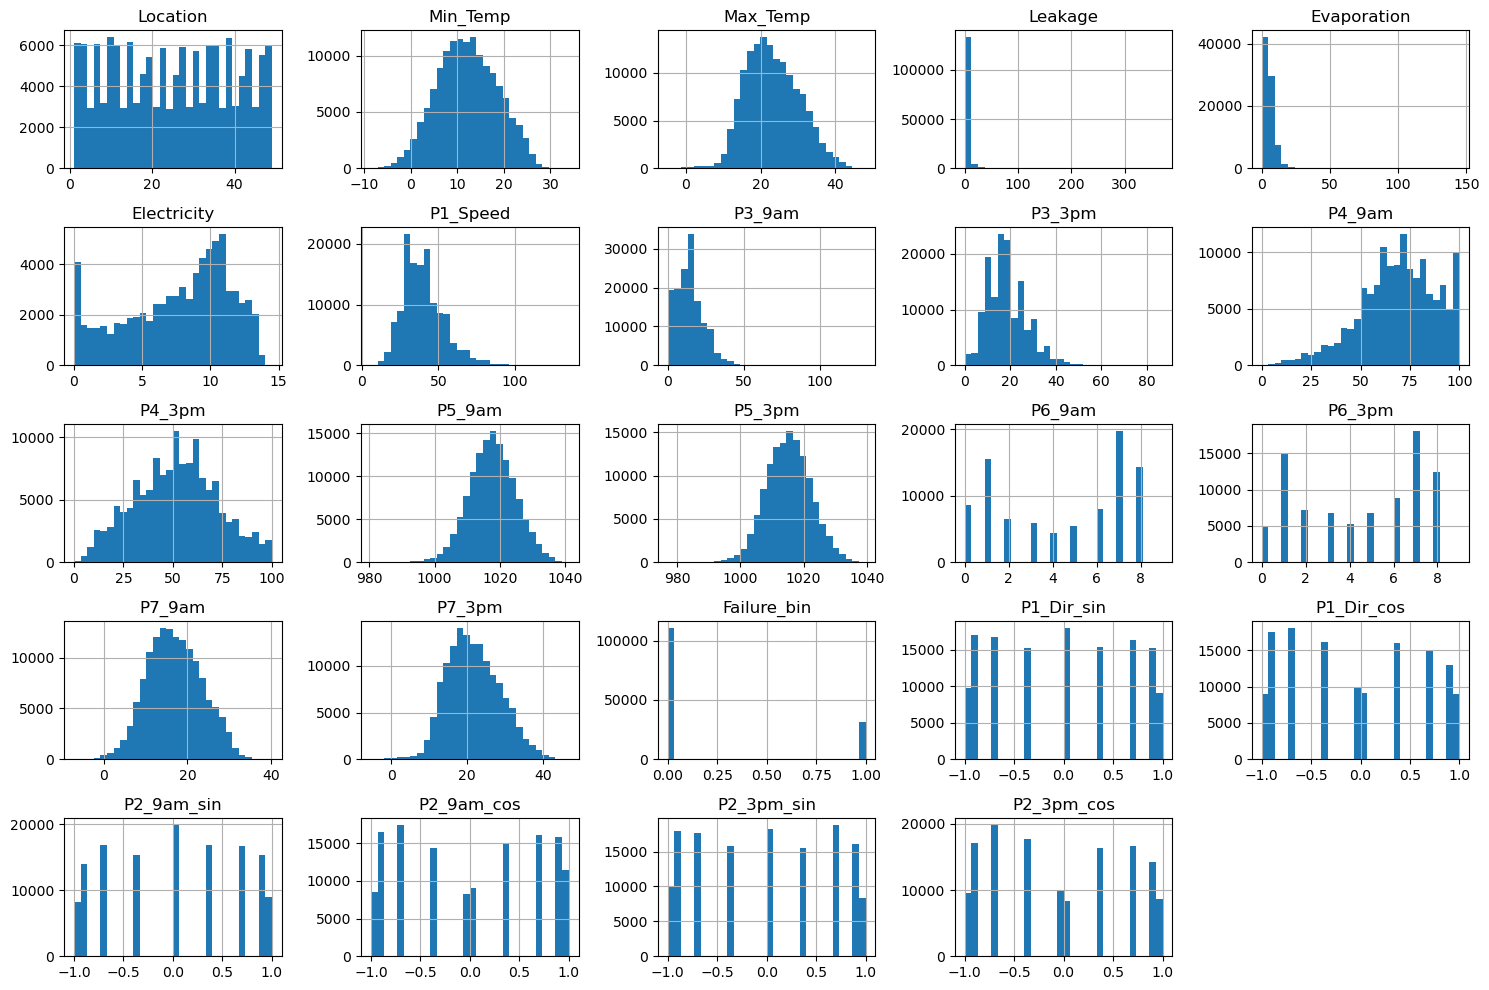

In [234]:
#Visulizamos las distribuciones de las variables
df.hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

In [235]:
# Vemos la proporción de nulos (NaN) en %
(df.isnull().mean().sort_values(ascending=False))*100

Electricity    47.692924
Evaporation    42.789026
P6_3pm         40.152469
P6_9am         37.735332
P5_9am          9.855619
P5_3pm          9.832411
P2_9am_cos      7.041838
P2_9am_sin      7.041838
P1_Dir_cos      6.561504
P1_Dir_sin      6.561504
P1_Speed        6.519308
P2_3pm_sin      2.656952
P2_3pm_cos      2.656952
P4_3pm          2.538803
P7_3pm          1.917113
P3_3pm          1.849599
P4_9am          1.247600
Leakage         0.988797
P3_9am          0.948007
P7_9am          0.635756
Min_Temp        0.447983
Max_Temp        0.226453
Location        0.000000
Failure_bin     0.000000
Date            0.000000
dtype: float64

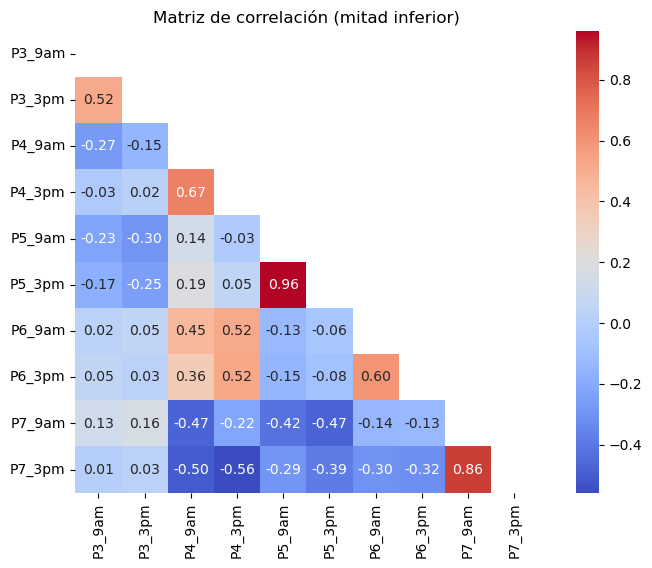

In [236]:
# Vemos las correlaciones entre los parametros que son medidos dos veces al día
variables = ['P3_9am','P3_3pm','P4_9am','P4_3pm','P5_9am','P5_3pm','P6_9am','P6_3pm','P7_9am','P7_3pm']  # ejemplo

correlaciones = df[variables].corr()
mask = np.triu(np.ones_like(correlaciones, dtype=bool))

plt.figure(figsize=(10, 6))
sns.heatmap(correlaciones, mask=mask, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Matriz de correlación (mitad inferior)")
plt.show()


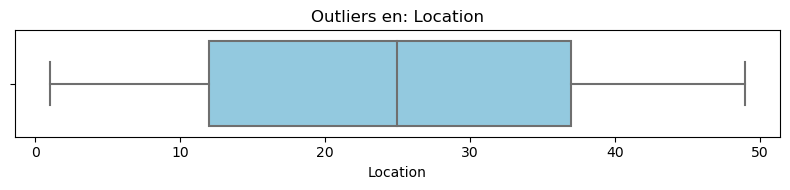

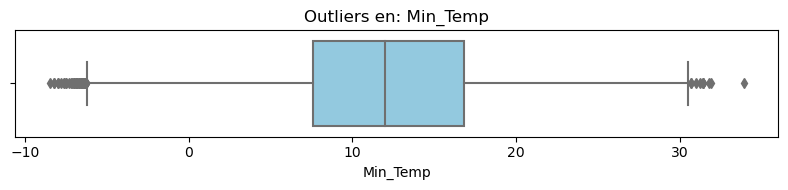

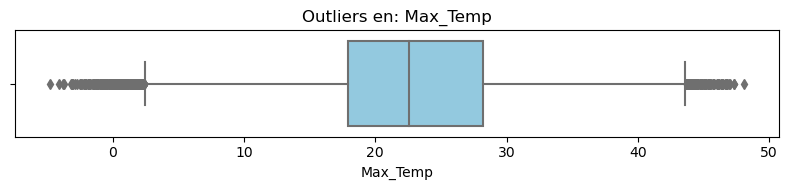

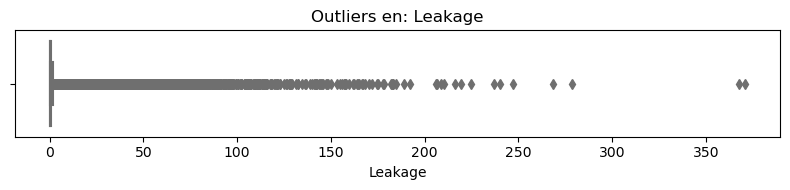

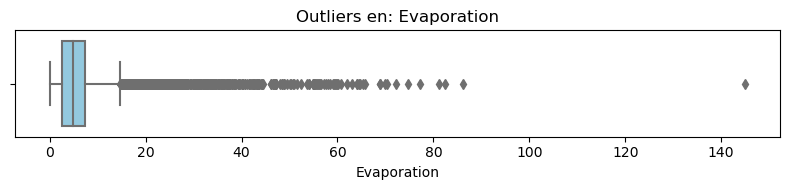

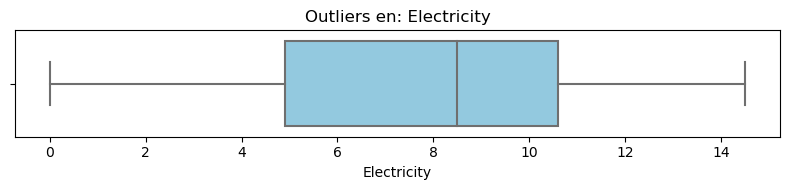

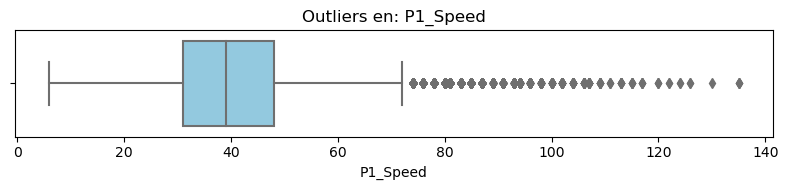

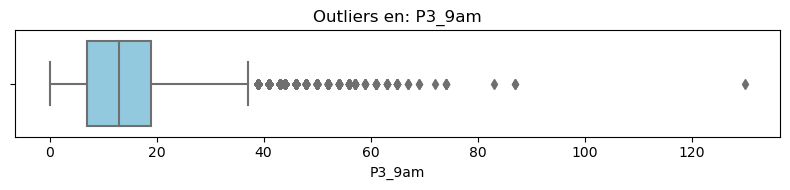

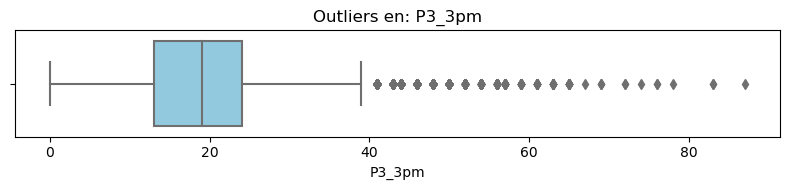

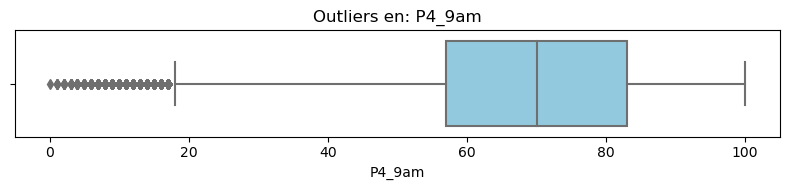

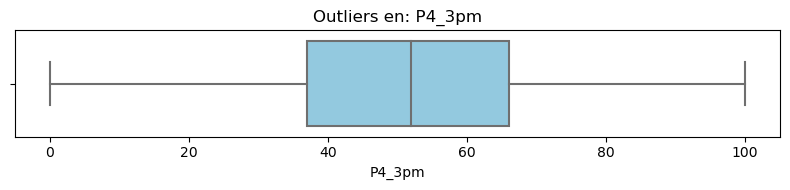

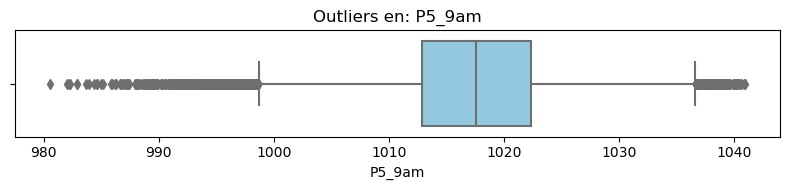

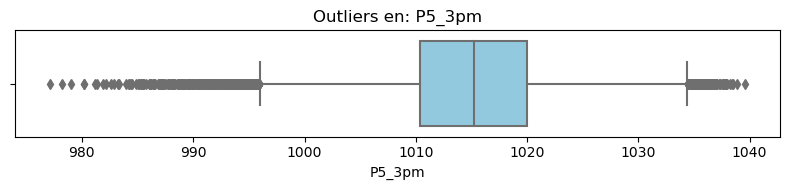

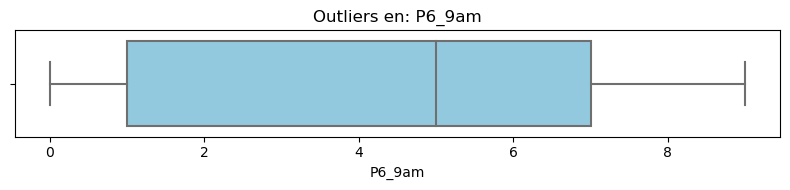

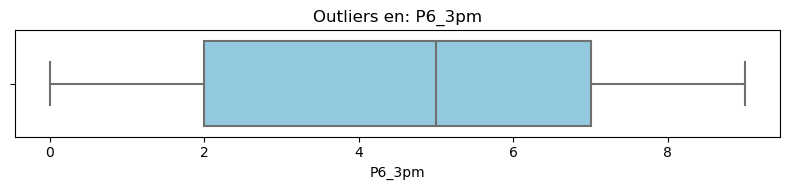

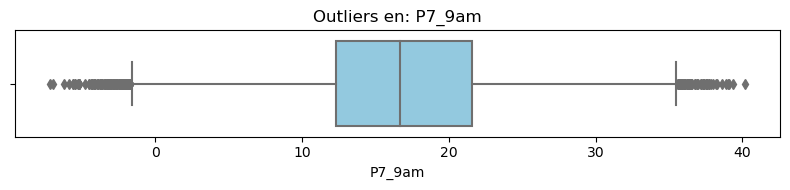

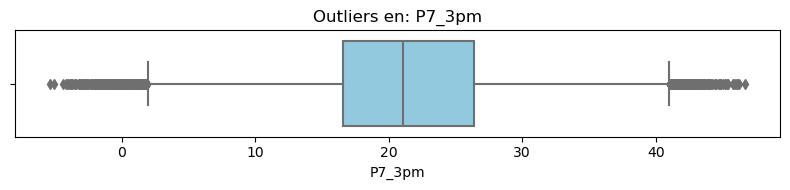

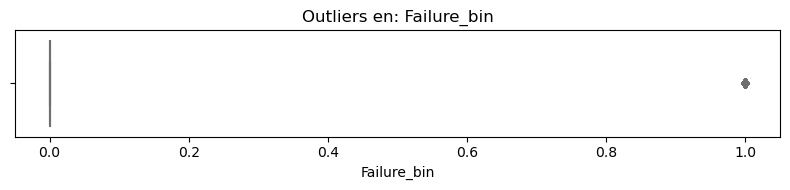

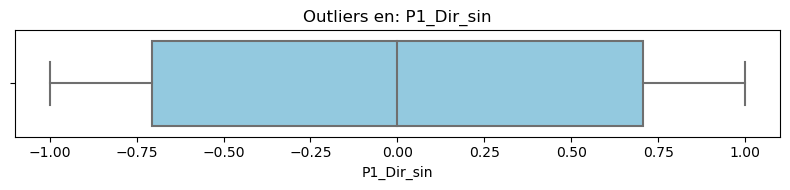

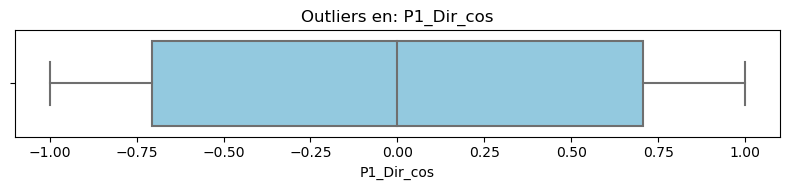

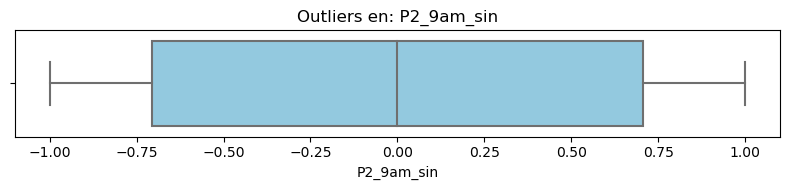

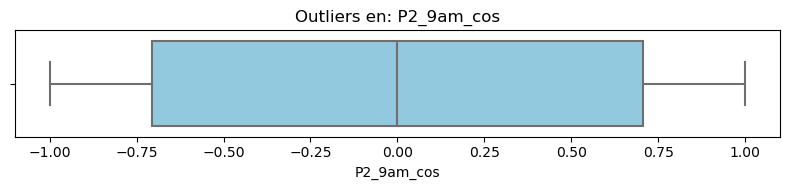

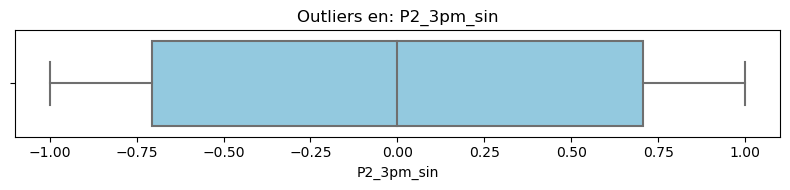

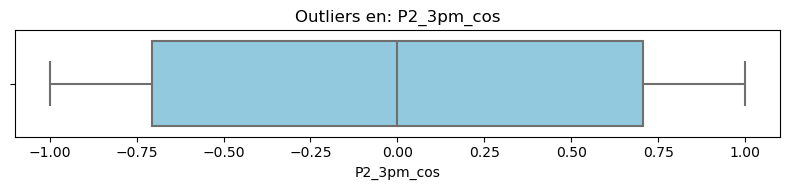

In [237]:
# Vemos los outliers que tienen las variables
numeric_cols = df.select_dtypes(include='number').columns
for col in numeric_cols:
    plt.figure(figsize=(8, 2))
    sns.boxplot(data=df, x=col, color='skyblue')
    plt.title(f'Outliers en: {col}')
    plt.tight_layout()
    plt.show()


In [238]:
outlier_counts = {}

for col in df.select_dtypes(include='number'):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)]
    outlier_counts[col] = len(outliers)
    
# Proporciones de outliers en %
outlier_counts = dict(sorted(outlier_counts.items(), key=lambda item: item[1], reverse=True))
for k, v in outlier_counts.items():
    print(f"{k}: {(v/len(df))*100} outliers")
df.head()

Failure_bin: 22.121342119513617 outliers
Leakage: 17.74208294360482 outliers
P1_Speed: 2.114028116714606 outliers
P3_3pm: 1.7286364307666342 outliers
Evaporation: 1.3741886028144845 outliers
P3_9am: 1.222985660334897 outliers
P4_9am: 0.9979394203652782 outliers
P5_9am: 0.8256383928885388 outliers
P5_3pm: 0.6371621669139831 outliers
P7_3pm: 0.5169030824302181 outliers
Max_Temp: 0.3228007004564219 outliers
P7_9am: 0.17370756647654947 outliers
Min_Temp: 0.04360270899411363 outliers
Location: 0.0 outliers
Electricity: 0.0 outliers
P4_3pm: 0.0 outliers
P6_9am: 0.0 outliers
P6_3pm: 0.0 outliers
P1_Dir_sin: 0.0 outliers
P1_Dir_cos: 0.0 outliers
P2_9am_sin: 0.0 outliers
P2_9am_cos: 0.0 outliers
P2_3pm_sin: 0.0 outliers
P2_3pm_cos: 0.0 outliers


,Date,Location,Min_Temp,Max_Temp,Leakage,Evaporation,Electricity,P1_Speed,P3_9am,P3_3pm,...,P6_3pm,P7_9am,P7_3pm,Failure_bin,P1_Dir_sin,P1_Dir_cos,P2_9am_sin,P2_9am_cos,P2_3pm_sin,P2_3pm_cos
0,12/1/2008,3,13.4,22.9,0.6,NaN,NaN,44.0,20.0,24.0,...,NaN,16.9,21.8,0,-1.000000,-1.836970e-16,-1.000000,-1.836970e-16,-0.923880,3.826834e-01
1,12/2/2008,3,7.4,25.1,0.0,NaN,NaN,44.0,4.0,22.0,...,NaN,17.2,24.3,0,-0.923880,3.826834e-01,-0.382683,9.238795e-01,-0.923880,-3.826834e-01
2,12/3/2008,3,12.9,25.7,0.0,NaN,NaN,46.0,19.0,26.0,...,2.0,21.0,23.2,0,-0.923880,-3.826834e-01,-1.000000,-1.836970e-16,-0.923880,-3.826834e-01
3,12/4/2008,3,9.2,28.0,0.0,NaN,NaN,24.0,11.0,9.0,...,NaN,18.1,26.5,0,0.707107,7.071068e-01,0.707107,-7.071068e-01,1.000000,6.123234e-17
4,12/5/2008,3,17.5,32.3,1.0,NaN,NaN,41.0,7.0,20.0,...,8.0,17.8,29.7,0,-1.000000,-1.836970e-16,0.923880,3.826834e-01,-0.707107,7.071068e-01


In [239]:
# Conociendo las distribuciones, los outliers y las correlaciones, notamos que los parametros que son medidos dos veces al día
# siguen una distribucion muy parecida, además de tener correlaciones relativamente altas,por lo que se calculó la media 
# de cada variable y se junto en una sola para mayor comodidad

df['P3_prmd'] = (df['P3_9am'] + df['P3_3pm']) / 2
df['P4_prmd'] = (df['P4_9am'] + df['P4_3pm']) / 2
df['P5_prmd'] = (df['P5_9am'] + df['P5_3pm']) / 2
df['P6_prmd'] = (df['P6_9am'] + df['P6_3pm']) / 2
df['P7_prmd'] = (df['P7_9am'] + df['P7_3pm']) / 2

df.drop(columns=['P3_9am','P3_3pm',
                 'P4_9am', 'P4_3pm', 
                 'P5_9am', 'P5_3pm',
                 'P6_9am', 'P6_3pm',
                 'P7_9am', 'P7_3pm'
                ], inplace=True)

col = 'Failure_bin'
cols = [c for c in df.columns if c != col] + [col]
df = df[cols]

# Con respecto a los outliers notamos que Leakage teine un valor alto, por lo que la cambiamos a su forma logarítmica
df['Leakage_log'] = np.log1p(df['Leakage'])
df.drop(columns=['Leakage'], inplace=True)
df.head()

,Date,Location,Min_Temp,Max_Temp,Evaporation,Electricity,P1_Speed,P1_Dir_sin,P1_Dir_cos,P2_9am_sin,P2_9am_cos,P2_3pm_sin,P2_3pm_cos,P3_prmd,P4_prmd,P5_prmd,P6_prmd,P7_prmd,Failure_bin,Leakage_log
0,12/1/2008,3,13.4,22.9,NaN,NaN,44.0,-1.000000,-1.836970e-16,-1.000000,-1.836970e-16,-0.923880,3.826834e-01,22.0,46.5,1007.40,NaN,19.35,0,0.470004
1,12/2/2008,3,7.4,25.1,NaN,NaN,44.0,-0.923880,3.826834e-01,-0.382683,9.238795e-01,-0.923880,-3.826834e-01,13.0,34.5,1009.20,NaN,20.75,0,0.000000
2,12/3/2008,3,12.9,25.7,NaN,NaN,46.0,-0.923880,-3.826834e-01,-1.000000,-1.836970e-16,-0.923880,-3.826834e-01,22.5,34.0,1008.15,NaN,22.10,0,0.000000
3,12/4/2008,3,9.2,28.0,NaN,NaN,24.0,0.707107,7.071068e-01,0.707107,-7.071068e-01,1.000000,6.123234e-17,10.0,30.5,1015.20,NaN,22.30,0,0.000000
4,12/5/2008,3,17.5,32.3,NaN,NaN,41.0,-1.000000,-1.836970e-16,0.923880,3.826834e-01,-0.707107,7.071068e-01,13.5,57.5,1008.40,7.5,23.75,0,0.693147


In [240]:
# Sobre los valores nulos, notamos que la mayoría se concentra en Electricity, Evaporation y P6, para evitar la perdida de data 
# se decide reemplaza los valores nulos de Evaporation y Eletricity por la mediana

df['Evaporation'] = df['Evaporation'].fillna(df['Evaporation'].median())
df['Electricity'] = df['Electricity'].fillna(df['Electricity'].median())
# Respecto a P6, se decide eliminarlo directemante 
df.drop(columns=['P6_prmd'], inplace=True)

df=df.dropna()
df.head()

,Date,Location,Min_Temp,Max_Temp,Evaporation,Electricity,P1_Speed,P1_Dir_sin,P1_Dir_cos,P2_9am_sin,P2_9am_cos,P2_3pm_sin,P2_3pm_cos,P3_prmd,P4_prmd,P5_prmd,P7_prmd,Failure_bin,Leakage_log
0,12/1/2008,3,13.4,22.9,4.8,8.5,44.0,-1.000000,-1.836970e-16,-1.000000,-1.836970e-16,-0.923880,3.826834e-01,22.0,46.5,1007.40,19.35,0,0.470004
1,12/2/2008,3,7.4,25.1,4.8,8.5,44.0,-0.923880,3.826834e-01,-0.382683,9.238795e-01,-0.923880,-3.826834e-01,13.0,34.5,1009.20,20.75,0,0.000000
2,12/3/2008,3,12.9,25.7,4.8,8.5,46.0,-0.923880,-3.826834e-01,-1.000000,-1.836970e-16,-0.923880,-3.826834e-01,22.5,34.0,1008.15,22.10,0,0.000000
3,12/4/2008,3,9.2,28.0,4.8,8.5,24.0,0.707107,7.071068e-01,0.707107,-7.071068e-01,1.000000,6.123234e-17,10.0,30.5,1015.20,22.30,0,0.000000
4,12/5/2008,3,17.5,32.3,4.8,8.5,41.0,-1.000000,-1.836970e-16,0.923880,3.826834e-01,-0.707107,7.071068e-01,13.5,57.5,1008.40,23.75,0,0.693147


# OLS

2.-Ejecute un modelo de probabilidad lineal (MCO) que permita explicar la probabilidad de que un dia se reporte fallo medido por sensor, a partir de las informacion disponible. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

**R**: Para ejecutar el modelo MCO se crea una matriz de correlaciones para eliminar variables muy correlacionadas, posterior a esto se ejecuta el modelo eliminando estas variables. Ya dropeadas las variables no deseadas se ejecutó el modelo, de esto se puede interpretar que la mayoría de las variables son significativas, esto puede deberse a la gran cantidad de data, a su vez la variablre que más influye negativamente a la variable dependiente es P4_prmd, la cual si aumenta en una unidad la probabilidad de falla aumenta en 0.1289, por otro lado la mayoria de las variables restante aportan positivamente, disminuyendo la probabilidad de falla al tener un valor negativo.

<Axes: >

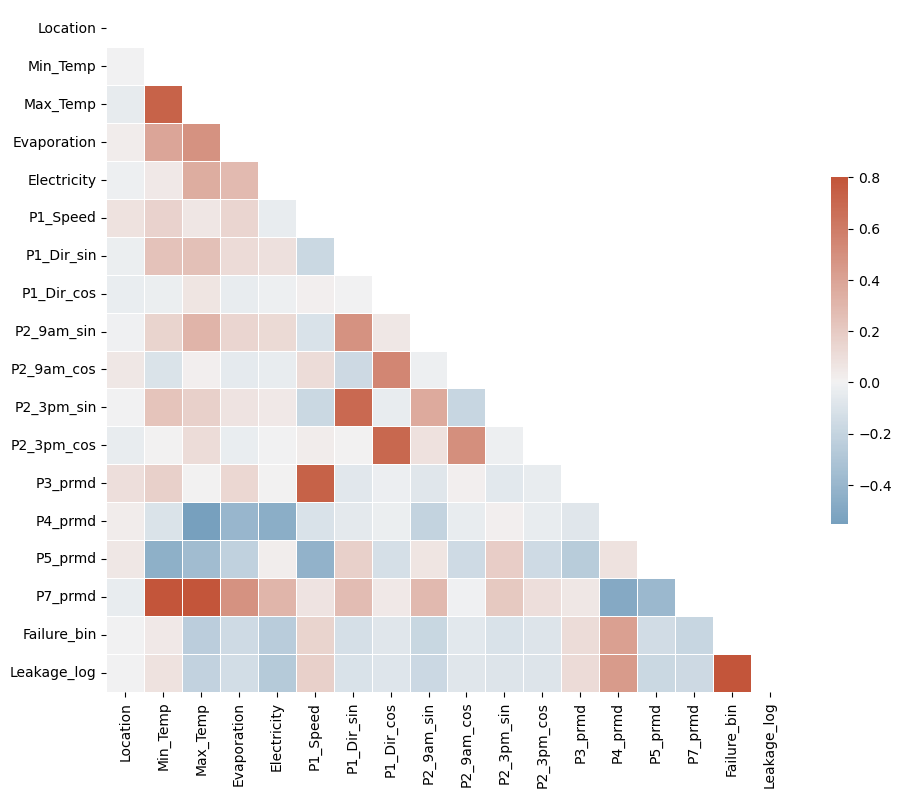

In [241]:
# Se crea la matriz de correlación
corr = df.corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(240, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [242]:
# Se crea el modelo OLS
y = df['Failure_bin']
# Se dropea los valores no deseados, como la variable dependiente y date, también se dropean P7_prmd y Leakage_log por
# por sus correlaciones
X = df.drop(['Failure_bin', 'Date', 'P7_prmd','Leakage_log'], axis=1)

# Se estandarizan los datos, dejamos fura las variables que no se desean estandarizar, como las direcciones y Location
no_est= ['P1_Dir_cos', 'P2_9am_cos', 'P2_3pm_sin', 'P2_3pm_cos', 'P2_9am_sin', 'P1_Dir_sin','Location']
cols_est = [col for col in X.columns if col not in no_estndr]

# Estandarizamos las variables estandarizadas
estandar = StandardScaler()
X_est = estandar.fit_transform(X[cols_est])
X_est = pd.DataFrame(X_est, columns=cols_est, index=X.index)
X_final = pd.concat([X_est, X[no_est]], axis=1)
X_final = sm.add_constant(X_final)

model = sm.OLS(y, X_final)
results = model.fit(cov_type='HC0')

print(results.summary())


                            OLS Regression Results                            
Dep. Variable:            Failure_bin   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.257
Method:                 Least Squares   F-statistic:                     2717.
Date:                Thu, 24 Apr 2025   Prob (F-statistic):               0.00
Time:                        23:46:58   Log-Likelihood:                -44786.
No. Observations:              112925   AIC:                         8.960e+04
Df Residuals:                  112909   BIC:                         8.976e+04
Df Model:                          15                                         
Covariance Type:                  HC0                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2376      0.002    110.854      

# Probit

3.-Ejecute un modelo probit para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

**R**: Para verificar la existencia de multicolinealidad se calculo el VIF de cada variable, la cual nos indicó que no existe en mayor medida, luego de esto se realizó el modelo Probit, este modelo resulta ser estadísticamente sifnificativo, en este caso todas las variables resultaron ser significativas. Los efectos marginales en el modelo Probit muestran cambios importantes en la magnitud de las asociaciones, en comparación con el modelo OLS. En general, las asociaciones se intensifican, especialmente para variables como la temperatura mínima y la temperatura máxima, donde un aumento de una unidad puede traducirse en un cambio de más de 10 puntos porcentuales en la probabilidad de falla. Dando un mejor entendimiento del modelo.

In [243]:
# Calculo VIF
X_const = add_constant(X) 
vif_data = pd.DataFrame()
vif_data["Variable"] = X_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]

print(vif_data)


       Variable           VIF
0         const  39438.107523
1      Location      1.033256
2      Min_Temp      4.054110
3      Max_Temp      5.592020
4   Evaporation      1.450385
5   Electricity      1.390771
6      P1_Speed      2.625612
7    P1_Dir_sin      2.265681
8    P1_Dir_cos      2.216234
9    P2_9am_sin      1.439005
10   P2_9am_cos      1.622673
11   P2_3pm_sin      2.026331
12   P2_3pm_cos      2.121965
13      P3_prmd      2.384595
14      P4_prmd      2.391992
15      P5_prmd      1.764535


In [244]:
# Ejecución modelo Probit
estandar = StandardScaler()
X_est = pd.DataFrame(estandar.fit_transform(X), columns=X.columns, index=X.index)
X_est = sm.add_constant(X_est)

model = sm.Probit(y, X_est)
probit_model = model.fit(cov_type='HC0')

# Ejecución efectos marginales
mfx = logit_results.get_margeff()
print(probit_model.summary())
print("\nEfectos marginales (Probit):")
print(mfx.summary())

Optimization terminated successfully.
         Current function value: 0.378725
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:            Failure_bin   No. Observations:               112925
Model:                         Probit   Df Residuals:                   112909
Method:                           MLE   Df Model:                           15
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.2891
Time:                        23:47:03   Log-Likelihood:                -42768.
converged:                       True   LL-Null:                       -60159.
Covariance Type:                  HC0   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.0972      0.006   -169.246      0.000      -1.110      -1.085
Location       -0.0338    

# Logit

4.- Ejecute un modelo logit para responder a la pregunta 2. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

**R**: Los resultados obtenido con el modelo Logit no difirene en mayor medida a comparación del Probit sobre los efectos marginales, pero en este modelo permite interpretar con mayor facilidad los coeficientes en terminos de odds-ratio, en donde seguimos tienendo a las variables de temperatura como las que más afectan a la variable dependiente, en este caso el aumento en una unidad de Max_temp disminuye la probabilidad de fallo en 0.947, y un aumento en Min_tempo aumenta la probabilidad en 0.875.

In [247]:
logit_model = sm.Logit(y, X_est)
logit_results = logit_model.fit(cov_type='HC0')  # errores robustos

# 4. Resumen del modelo
print(logit_results.summary())

# 5. Efectos marginales
mfx = logit_results.get_margeff()
print("\nEfectos marginales (Logit):")
print(mfx.summary())

Optimization terminated successfully.
         Current function value: 0.377860
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            Failure_bin   No. Observations:               112925
Model:                          Logit   Df Residuals:                   112909
Method:                           MLE   Df Model:                           15
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                  0.2907
Time:                        23:47:35   Log-Likelihood:                -42670.
converged:                       True   LL-Null:                       -60159.
Covariance Type:                  HC0   LLR p-value:                     0.000
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -1.9403      0.012   -160.100      0.000      -1.964      -1.917
Location       -0.0607    

5.- Comente los resultados obtenidos en 2, 3 y 4. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

**R**: Las diferencias de los modelos se encuentran principalente en sus coeficientes, dando resultados distintos en cada uno, lo cual afecta a la interpretacion de las variables explicativas, esto porque el modelo OLS no es adecuado para trabajar con una variable independiente binaria, a diferencia de los modelos Probit y Logit. Por otro lado, entre estos dos modelos el mas adecuado sería el modelo Logit, particularmente por los odds ratios, lo cual lo hace particularmente útil para interpretar el impacto de las variables. Las variables que se identifican como robustas según los modelos son Min_tempo, Max_temp, Evaporation, P1_speed y P4_prmd, las cuales siguieron una relación consistente en todos los modelos.



# Poisson

6.- Agregue la data a nivel mensual, usando la data promedio de las variables (ignorando aquellas categoricas, como la direccion del viento). En particular, genere una variable que cuente la cantidad de fallos observados en un mes, utilice un valor de 0 si en ese mes no se reporto fallos en ningun dia. Use un modelo Poisson para explicar el numero de fallas por mes. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

**R**: Se configuro la data para contar el numero de fallos por mes para luego ejecutar el modelo Poisson. En este modelo casi todas las variables resultaron ser significativas, se puede identificar a las variables P7_prmd, P3_prmd y P4_prmd son las que muestran un efecto positivo mas alto sobre el conteo de fallas, en cambio Min_speed y P1_speed son las variables que mas negativamente aportan al conteo de fallas.



In [248]:
# Configuración para determinar el numero de fallos por mes
df['Date'] = pd.to_datetime(df['Date'])
df['YearMonth'] = df['Date'].dt.to_period('M')
cols_no = ['Date','P1_Dir_sin','P1_Dir_cos','P2_9am_sin','P2_9am_cos','P2_3pm_sin','P2_3pm_cos'] # Categoricas
num_cols = df.drop(columns=cols_to_ignore).select_dtypes(include='number').columns.tolist()

mensual_df = df.groupby('YearMonth')[num_cols].mean()
mensual_df['Failure_Cont'] = df.groupby('YearMonth')['Failure_bin'].sum()

# Ejecutación del modelo
y = mensual_df['Failure_Cont']
X = mensual_df.drop(columns=['Failure_Cont','Failure_bin','Location','Leakage_log'])

estandar = StandardScaler()
X_est = estandar.fit_transform(X)
X_est = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_est = sm.add_constant(X_scaled)
y = mensual_df['Failure_Cont']
modelo_poisson = sm.GLM(y, X_scaled, family=sm.families.Poisson()).fit()

print(modelo_poisson.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:           Failure_Cont   No. Observations:                  113
Model:                            GLM   Df Residuals:                      103
Model Family:                 Poisson   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1082.3
Date:                Thu, 24 Apr 2025   Deviance:                       1375.7
Time:                        23:47:37   Pearson chi2:                 1.18e+03
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.2718      0.008    679.937      

# Alpha

7.- Determine sobre dispersion en la data y posible valor optimo de alpha para un modelo Binomial Negativa.

**R**: Para la determinación de la sobredisperisión se dividió Deviance/ Df resiudals, con esto se llego a un resultado de 13.35, el cual indica una sibredispersion alta, dando a entender que Poisson no es una buena elección como modelo en este caso.
Con respecto a la estimación del alpha se utlizo un modelo OLS para estimarlo, dando como resultado 1.0314.

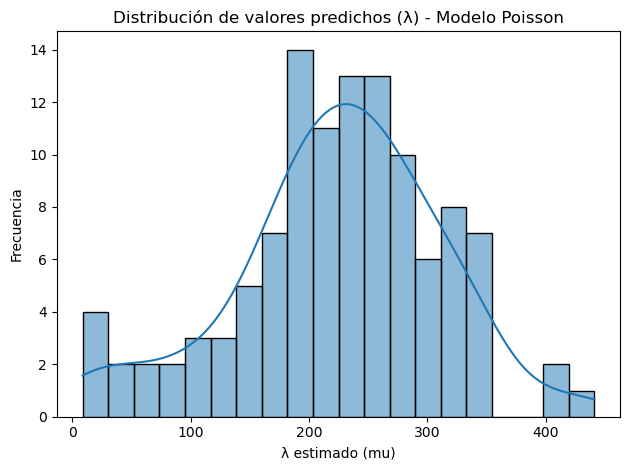

Sobredispersión: 13.356025476197102


In [249]:
#Grafico de la destribución de valores predichos de alpha en le modelo alpha
mensual_df['plambda'] = modelo_poisson.mu
sns.histplot(data=mensual_df, x="plambda", bins=20, kde=True)
plt.title("Distribución de valores predichos (λ) - Modelo Poisson")
plt.xlabel("λ estimado (mu)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()
# Calculo sobredispersión
sobredispersion = modelo_poisson.deviance / modelo_poisson.df_resid
print("Sobredispersión:", sobredispersion)


In [250]:
# Modelo OLS
prediccion = poisson_model.predict(X_scaled)
aux = ((mensual_df['Failure_Cont'] - prediccion)**2 - prediccion) / prediccion
aux_model = sm.OLS(aux, prediccion).fit()
print(aux_model.summary())

coef_aux = aux_model.params[0]
print(f"\nCoeficiente de la regresión auxiliar: {coef_aux:.4f}")

# Estimación de alpha 
alpha_estimado = np.exp(coef_aux)  

print(f"Alpha estimado (exp(coef)): {alpha_estimado:.4f}")

                                 OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.167
Model:                            OLS   Adj. R-squared (uncentered):              0.160
Method:                 Least Squares   F-statistic:                              22.53
Date:                Thu, 24 Apr 2025   Prob (F-statistic):                    6.16e-06
Time:                        23:47:42   Log-Likelihood:                         -477.59
No. Observations:                 113   AIC:                                      957.2
Df Residuals:                     112   BIC:                                      959.9
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

# Binomial negativa

8.- Usando la informacion anterior, ejecute un modelo Binomial Negativa para responder a la pregunta 6. Seleccione las variables dependientes a incluir en el modelo final e interprete su significado.

**R**: Este modelo logra corregir la sobredispersion del modelo anterior, pero se puede notar que no exiten muchas variables significativas, solo P3_prmd y P4_prmd logran ser significativas, con coeficientes de 1.1492 y 0.8132, aportando positivamente al conteo de fallos por mes.

In [251]:
# Ejecución modelo Binomial Negativo
negbin=sm.GLM(y,X_scaled,family=sm.families.NegativeBinomial(alpha=1.0314)).fit()
print(negbin.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           Failure_Cont   No. Observations:                  113
Model:                            GLM   Df Residuals:                      103
Model Family:        NegativeBinomial   Df Model:                            9
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -704.59
Date:                Thu, 24 Apr 2025   Deviance:                       15.097
Time:                        23:47:45   Pearson chi2:                     9.85
No. Iterations:                    19   Pseudo R-squ. (CS):             0.3169
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           5.2125      0.096     54.181      

9.- Comente los resultados obtenidos en 6, 7 y 8. ¿Cuáles y por qué existen las diferencias entre los resultados?. En su opinión, ¿Cuál sería el más adecuado para responder la pregunta de investgación y por qué? ¿Qué variables resultaron ser robustas a la especificación?

**R**: Entre los modelos exiten diferencias de significancia, mientral que en Poisson casi todas las variables son significativas, en la Binomial Negativa tan solo dos los son, además el modelos de Poisson resulto tener una sobredispersión alta, por lo que no es una buena elección de modelo, en cambio el modelo Binomial Negativo corrige esta sobredispresión, por lo que este modelo sería el adecuado para responder la pregunta de investigación. Las variables robustas resultaron ser P3_prmd y P4_prmd, las cuales son consistentes en los dos modelos.


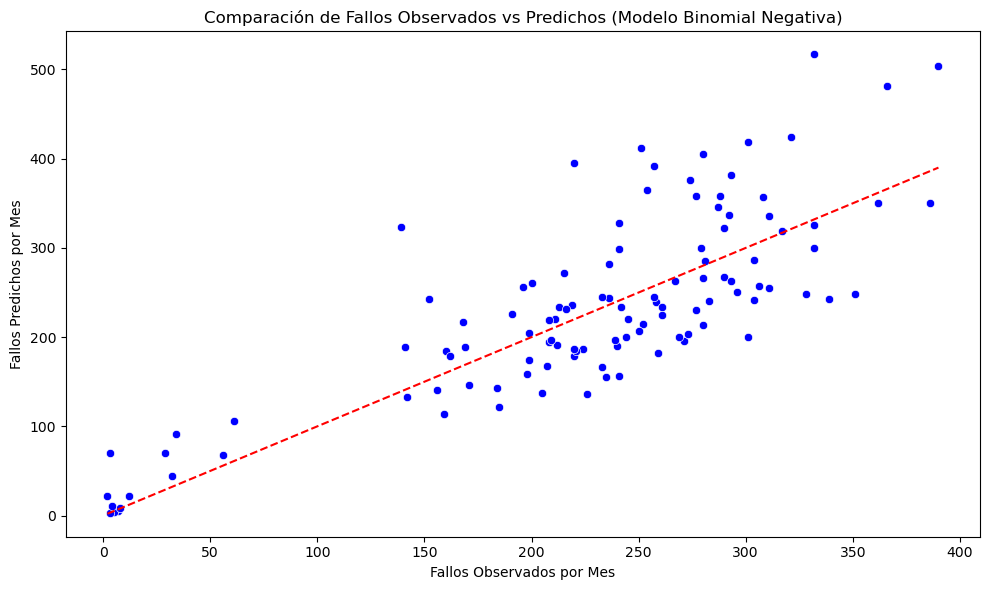

In [252]:
# Visualizacion de datos Fallos observados v/s Predichos
modelo_nb = sm.GLM(y, X, family=sm.families.NegativeBinomial(alpha=1.0)).fit()
mensual_df['ypred'] = modelo_nb.predict(X)  
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mensual_df, x='Failure_Cont', y='ypred', color='blue')
plt.plot(
    [mensual_df['Failure_Cont'].min(), mensual_df['Failure_Cont'].max()],
    [mensual_df['Failure_Cont'].min(), mensual_df['Failure_Cont'].max()],
    'r--'
)
plt.xlabel('Fallos Observados por Mes')
plt.ylabel('Fallos Predichos por Mes')
plt.title('Comparación de Fallos Observados vs Predichos (Modelo Binomial Negativa)')
plt.tight_layout()
plt.show()